In [43]:
import datautil
from os import path
import importlib
importlib.reload(datautil)

<module 'datautil' from '/home/sfluor/projects/driving_dataset/datautil.py'>

In [44]:
df, loader, scaler = datautil.create_loader(45000, workers=8)

In [45]:
df.describe()

,steering,steering_clipped,steering_scaled
count,45406.000000,45406.000000,45406.000000
mean,1.745058,1.229059,0.504552
std,30.916780,26.734230,0.099016
min,-159.930000,-135.000000,0.000000
25%,-5.450000,-5.450000,0.479815
50%,1.010000,1.010000,0.503741
75%,8.870000,8.870000,0.532852
max,501.780000,135.000000,1.000000


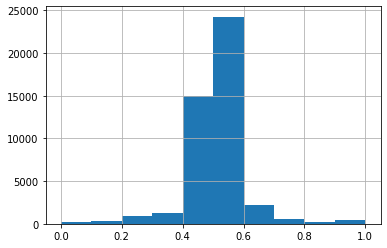

In [46]:
df['steering_scaled'].hist()

In [47]:
import torchvision.models as models
import torch.nn as nn
import torch

model = models.resnet18(pretrained=True)

# Strip the last linear layer
model.fc = nn.Sequential()

In [48]:
# Test on an image
in_tensor = datautil.load_img(df['image'].values[0]).unsqueeze(0)

print(in_tensor.shape)

with torch.no_grad():
    output = model(in_tensor)

print(output.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 512])


In [55]:
import numpy as np

with open("dataset/resnet18_clipped/y.data", "wb") as f:
    np.save(f, y)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [57]:
import xgboost

regr = xgboost.XGBRegressor()

In [58]:
regr.fit(X_train, y_train)

[16:58:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Text(0, 0.5, 'ground truth')

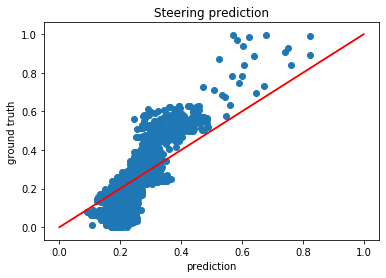

In [61]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

plt.ion()

print(f"MSE Error: {metrics.mean_squared_error(y_pred, y_test)}, max error: {metrics.max_error(y_pred, y_test)}")

plt.scatter(y_pred, y_test)
plt.plot([[0, 0], [1, 1]], color='red')
plt.title("Steering prediction")
plt.xlabel("prediction")
plt.ylabel("ground truth")

In [31]:
p = datautil.Pipeline(model, regr)

In [32]:
p.predict([datautil.load_img(df['image'].values[100], process=False)])

array([0.23788679], dtype=float32)